## Gene-RNA-Protein abundance

In the previous chapter we introduced the identification of non-canonical products of the genome. We are now going to investigate how the abundance of gene, transcript, and proteins relate to each other. 

### From genes to proteins and proteoforms

By combining multiple omics, researchers aim to improve the characterization of samples, understand the mechanisms underlying medical conditions, and find new druggable targets. In cancer research, the [National Cancer Institute’s Clinical Proteomic Tumor Analysis Consortium (CPTAC)](https://proteomics.cancer.gov/programs/cptac) conducted some of the most comprehensive proteogenomic studies, all available [online](https://cptac-data-portal.georgetown.edu/studies). Importantly, the data generated in CPTAC can be accessed and mined, and has become a reference resource in the field. 

Recent large-scale proteogenomic studies have yielded fundabmental knowledge on cancer and are exemplary in how to combine, interpret, and disseminate multiple omics data. We will not have the time to detail the full extent of the analyses conducted, it is recommended to navigate these seminal papers, and conduct the analyses on the available data before starting one's own.

### R Libraries

In the following We will need the following libraries. If they are not installed, an error will be thrown, install them using the `install.packages` function.

In [1]:
library(conflicted) # A very convenient package to avoid and resolve namespace conflicts
library(janitor) # A package to clean tables
library(tidyr) # A reference package to tidy data
library(dplyr) # A reference package to manipulate data
library(ggplot2) # A reference package to plot data
library(scico) # Color palettes for scientific data visualization
library(gtable) # A package to manipulate and arrange plots
library(grid) # A package to draw plots
library(mclust) # A package for clustering
library(igraph) # A package to manipulate graphs
library(glue) # A package to put variables in strings.

conflict_prefer("filter", "dplyr") # Conflict resolution for the 'filter' function 

theme_set(theme_bw(base_size = 13)) # Theme to use for all plots

Warning message:
"package 'conflicted' was built under R version 3.6.3"
Warning message:
"package 'janitor' was built under R version 3.6.3"
Warning message:
"replacing previous import 'vctrs::data_frame' by 'tibble::data_frame' when loading 'dplyr'"
Warning message:
"package 'tidyr' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Warning message:
"package 'scico' was built under R version 3.6.3"
Warning message:
"package 'gtable' was built under R version 3.6.3"
Warning message:
"package 'mclust' was built under R version 3.6.3"
Package 'mclust' version 5.4.7
Type 'citation("mclust")' for citing this R package in publications.

Warning message:
"package 'igraph' was built under R version 3.6.3"
Warning message:
"package 'glue' was built under R version 3.6.3"
[conflicted] Will prefer dplyr::filter over any other package



### Genotype - peptide abundance relationship

##### _❔ If a genetic variant can change the amino acid of a protein, what peptides do we expect to find? How should the peptide abundance relate to the genotype of the patient? What are the hypotheses underlying this model?_

We will use again the proteogenomic analysis by [Johansson _et al._](https://www.nature.com/articles/s41467-019-09018-y). Figure 7h displays the intensity of peptides relative to the allelic statuses of different patients.

![Figure_7h](resources/images/Fig7h.png?raw=true "Johansson et al. Fig 7h")

> Figure 7h in Johansson _et al._.

Note that the genotyping data corresponding to the peptide intensities were not made available, but more examples can be found in [Supplementary Figure 15](../resources/Johansson_et_al_breast_cancer_quantitative_proteome_and_proteogenomic_landscape/supplementary_information.pdf).

##### 💬 Do the results presented follow a linear trend? What can affect the linearity of the relationship between number of alleles and intensity distribution? 

### RNA vs. protein abundance

[Krug _et al._](https://doi.org/10.1016/j.cell.2020.10.036) recently released a similar characterization of the proteogenomic landscape of breast cancer, combining whole exome sequencing, RNA sequencing, and proteomics covering whole proteome analysis as well as phosphorylation and acetylation.

##### ❔ How would you map a transcript from RNA-seq data to proteomics data? What about the other omic layers - exome, phosphorylation, acetylation? 

In the [Table S2](resources/krug_et_al_2020/mmc2.xlsx), the authors provide abundance values for the different omics levels.

##### ❔ What differences do you observe in the reporting of the data compared to the other workshops in this course? Can you find the information that you need to match the quantitative values? How did the authors proceed?

##### ❔ How much do you expect mRNA abundance levels to correlate with protein abundance levels? What can alter this correlation?

The different tables were exported as text files in the [resources/krug_et_al_2020](resources/krug_et_al_2020) folder.

##### 👨‍💻 Load the RNA and protein data in R and merge them into a single data frame.

In [2]:
# Read the tables and use the clean_names function from the janitor package to standardize the names of the columns

rnaDF <- read.table(
    file = "resources/krug_et_al_2020/mRNA.gz",
    header = T,
    sep = "\t",
    comment.char = "",
    quote = "",
    stringsAsFactors = F
) %>%
    clean_names()

proteinDF <- read.table(
    file = "resources/krug_et_al_2020/proteins.gz",
    header = T,
    sep = "\t",
    comment.char = "",
    quote = "",
    stringsAsFactors = F
) %>%
    clean_names()

# Format to have one quantitative value per row, this is called pivoting the data from wide to long. While we are at it, we keep only the columns that we want and use the same name for the column containing the identifier to use for merging.

proteinLongDF <- proteinDF  %>% 
    select(
        protein_id = id,
        gene_id = gene_symbol,
        starts_with("cpt"),
        starts_with("x")
    ) %>% 
    pivot_longer(
        cols = starts_with(c("x", "cpt")),
        names_to = "tumor",
        values_to = "protein_abundance"
    )

rnaLongDF <- rnaDF  %>% 
    select(
        gene_id = id,
        gene_description = description,
        starts_with("cpt"),
        starts_with("x")
    ) %>% 
    pivot_longer(
        cols = starts_with(c("x", "cpt")),
        names_to = "tumor",
        values_to = "mRNA_abundance"
    )

# Merge, here we don't have much of a choice and must merge based on gene name

rnaProteinDF <- proteinLongDF %>% 
    full_join(
        rnaLongDF,
        by = c("gene_id", "tumor")
    )

##### ❔ What is the share of missing values for protein abundances? mRNA? Both?

##### 💬 How can we deal with these missing values?

##### 👨‍💻 Plot the protein abundance estimates against mRNA for the tumor 'CPT000814' and compute the correlation coefficient.

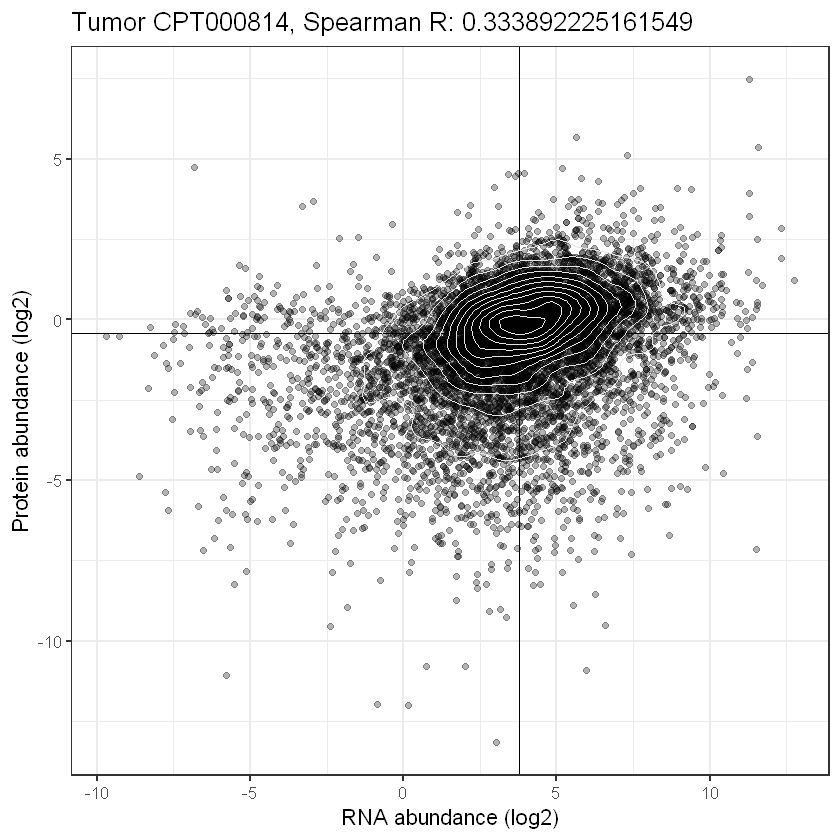

In [3]:
# Correlation for CPT000814

plotDF <- rnaProteinDF  %>% 
    filter(
        tumor == "cpt000814" & !is.na(mRNA_abundance) & !is.na(protein_abundance)
    )

correlationValue <- cor(
    x = plotDF$mRNA_abundance, 
    y = plotDF$protein_abundance, 
    use = "pairwise.complete.obs", 
    method = "spearman"
)

ggplot(
    data = plotDF
) +
    geom_hline(
        yintercept = median(plotDF$protein_abundance),
        col = "black"
    ) +
    geom_vline(
        xintercept = median(plotDF$mRNA_abundance),
        col = "black"
    ) +
    geom_point(
        mapping = aes(
            x = mRNA_abundance,
            y = protein_abundance
        ),
        alpha = 0.3
    ) +
    geom_density_2d(
        mapping = aes(
            x = mRNA_abundance,
            y = protein_abundance
        ),
        col = "grey90"
    ) +
    scale_x_continuous(
        name = "RNA abundance (log2)"
    ) +
    scale_y_continuous(
        name = "Protein abundance (log2)"
    ) +
    ggtitle(
        glue("Tumor CPT000814, Spearman R: {correlationValue}")
    )

##### ❔ What is the difference between Pearson and Spearman correlations?

##### ❔ What can explain the lack of correlation between the two abundance estimates?

##### 👨‍💻 Plot the protein abundance estimates against mRNA across all tumors for the proteins 'NP_000883.2', 'NP_000243.1', and 'NP_000035.2'.

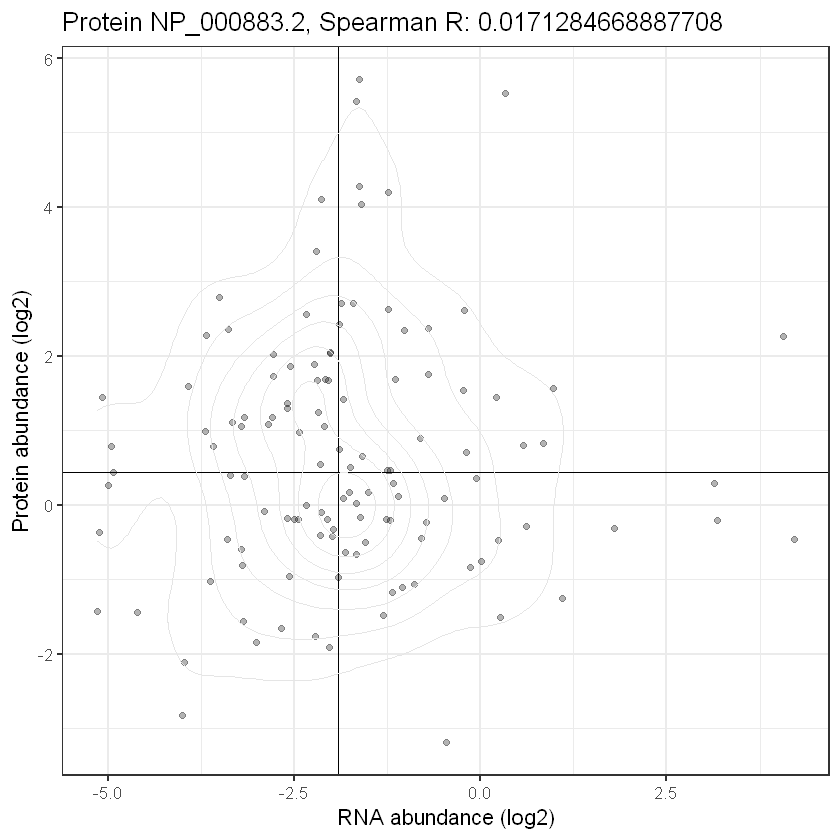

In [4]:
# NP_000883.2

proteinId <- "NP_000883.2"

plotDF <- rnaProteinDF  %>% 
    filter(
        protein_id == proteinId & !is.na(mRNA_abundance) & !is.na(protein_abundance)
    )

correlationValue <- cor(
    x = plotDF$mRNA_abundance, 
    y = plotDF$protein_abundance, 
    use = "pairwise.complete.obs", 
    method = "spearman"
)

ggplot(
    data = plotDF
) +
    geom_hline(
        yintercept = median(plotDF$protein_abundance),
        col = "black"
    ) +
    geom_vline(
        xintercept = median(plotDF$mRNA_abundance),
        col = "black"
    ) +
    geom_point(
        mapping = aes(
            x = mRNA_abundance,
            y = protein_abundance
        ),
        alpha = 0.3
    ) +
    geom_density_2d(
        mapping = aes(
            x = mRNA_abundance,
            y = protein_abundance
        ),
        col = "grey90"
    ) +
    scale_x_continuous(
        name = "RNA abundance (log2)"
    ) +
    scale_y_continuous(
        name = "Protein abundance (log2)"
    ) +
    ggtitle(
        glue("Protein {proteinId}, Spearman R: {correlationValue}")
    )

##### ❔ How do you interpret this plot?

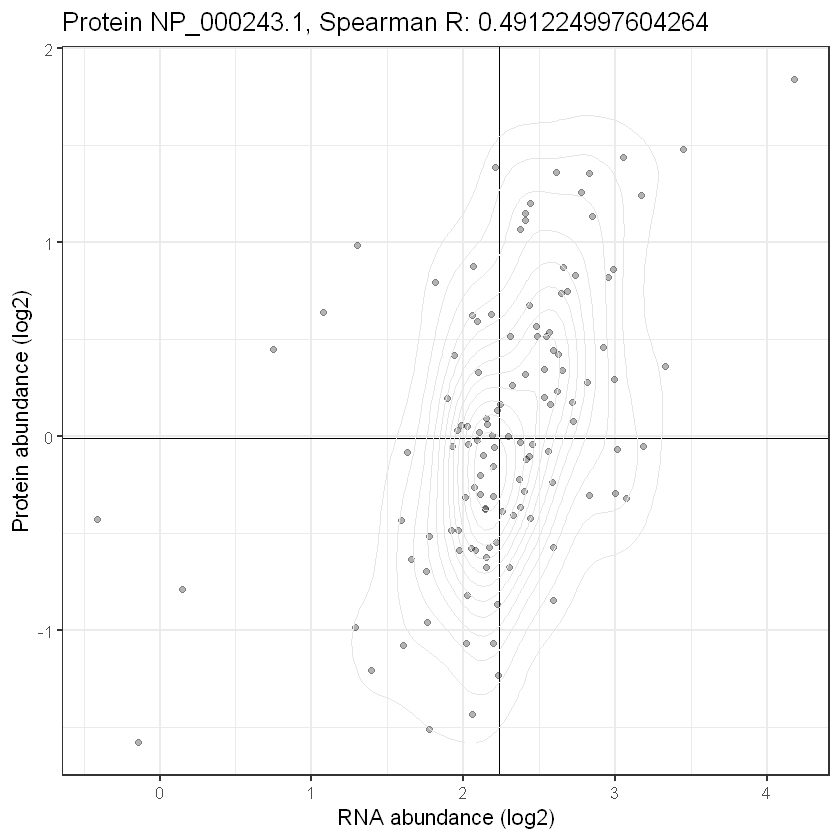

In [5]:
# NP_000243.1

proteinId <- "NP_000243.1"

plotDF <- rnaProteinDF  %>% 
    filter(
        protein_id == proteinId & !is.na(mRNA_abundance) & !is.na(protein_abundance)
    )

correlationValue <- cor(
    x = plotDF$mRNA_abundance, 
    y = plotDF$protein_abundance, 
    use = "pairwise.complete.obs", 
    method = "spearman"
)

ggplot(
    data = plotDF
) +
    geom_hline(
        yintercept = median(plotDF$protein_abundance),
        col = "black"
    ) +
    geom_vline(
        xintercept = median(plotDF$mRNA_abundance),
        col = "black"
    ) +
    geom_point(
        mapping = aes(
            x = mRNA_abundance,
            y = protein_abundance
        ),
        alpha = 0.3
    ) +
    geom_density_2d(
        mapping = aes(
            x = mRNA_abundance,
            y = protein_abundance
        ),
        col = "grey90"
    ) +
    scale_x_continuous(
        name = "RNA abundance (log2)"
    ) +
    scale_y_continuous(
        name = "Protein abundance (log2)"
    ) +
    ggtitle(
        glue("Protein {proteinId}, Spearman R: {correlationValue}")
    )

##### ❔ How do you interpret this plot?

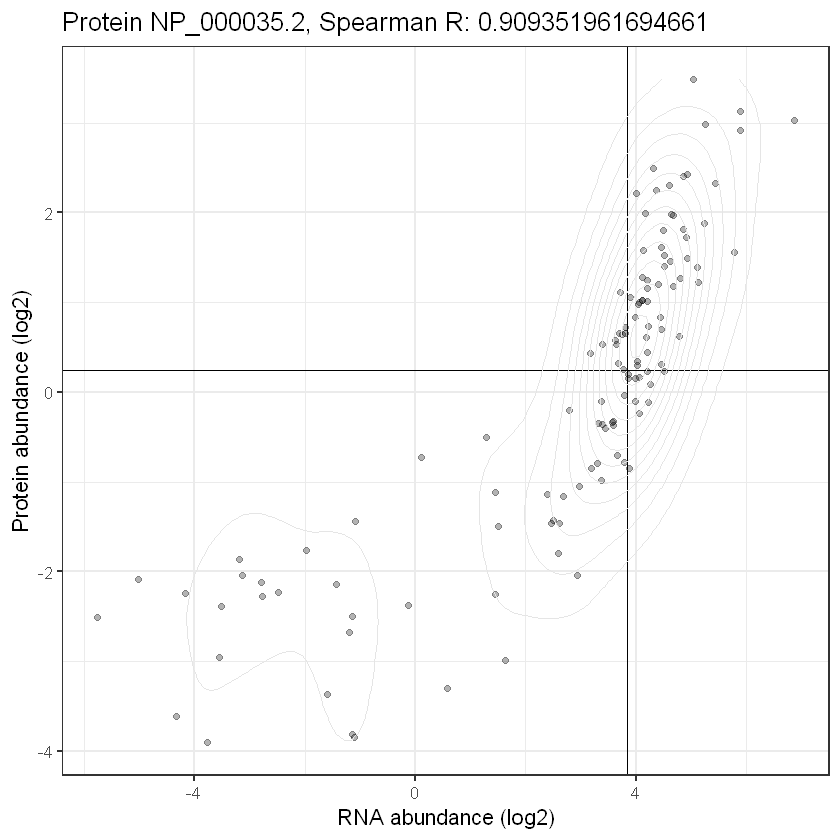

In [6]:
# NP_000035.2

proteinId <- "NP_000035.2"

plotDF <- rnaProteinDF  %>% 
    filter(
        protein_id == proteinId & !is.na(mRNA_abundance) & !is.na(protein_abundance)
    )

correlationValue <- cor(
    x = plotDF$mRNA_abundance, 
    y = plotDF$protein_abundance, 
    use = "pairwise.complete.obs", 
    method = "spearman"
)

ggplot(
    data = plotDF
) +
    geom_hline(
        yintercept = median(plotDF$protein_abundance),
        col = "black"
    ) +
    geom_vline(
        xintercept = median(plotDF$mRNA_abundance),
        col = "black"
    ) +
    geom_point(
        mapping = aes(
            x = mRNA_abundance,
            y = protein_abundance
        ),
        alpha = 0.3
    ) +
    geom_density_2d(
        mapping = aes(
            x = mRNA_abundance,
            y = protein_abundance
        ),
        col = "grey90"
    ) +
    scale_x_continuous(
        name = "RNA abundance (log2)"
    ) +
    scale_y_continuous(
        name = "Protein abundance (log2)"
    ) +
    ggtitle(
        glue("Protein {proteinId}, Spearman R: {correlationValue}")
    )

##### ❔ How do you interpret this plot?

##### 👨‍💻 For each protein, compute the correlation of the protein and mRNA abundance estimates across all tumors and plot the values as violin and box plots

`summarise()` ungrouping output (override with `.groups` argument)



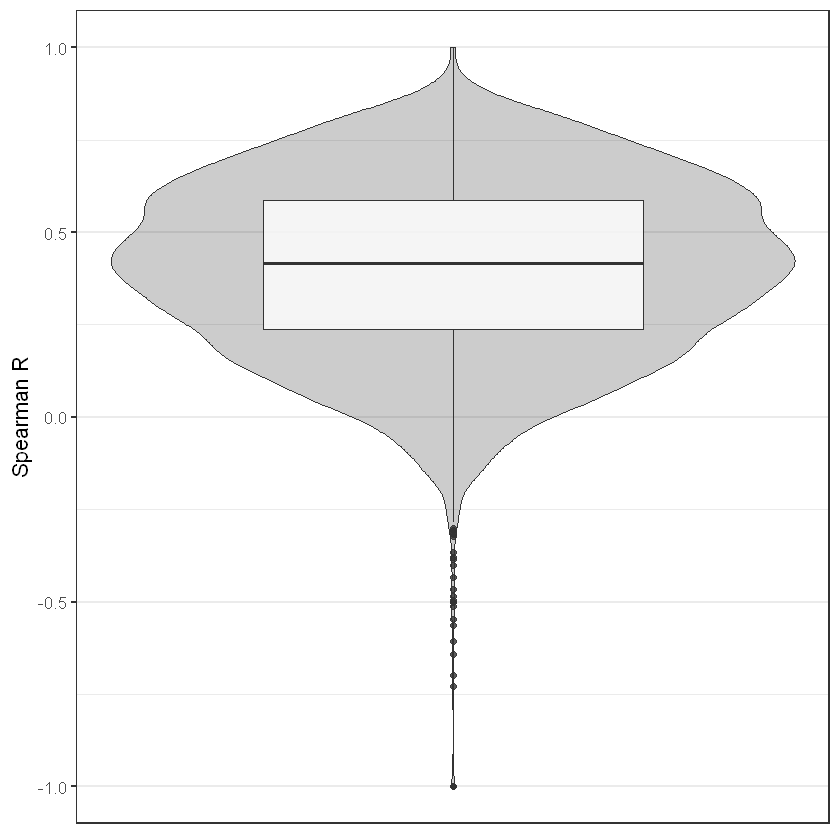

In [7]:
# Compute the correlation between mRNA and protein abundance levels across tumors for every protein id

rnaProteinCorrelationDF <- rnaProteinDF  %>% 
    group_by(
        protein_id
    ) %>% 
    summarize(
        r = cor(
            x = protein_abundance, 
            y = mRNA_abundance, 
            use = "pairwise.complete.obs", 
            method = "spearman"
        )
    ) %>% 
    filter(
        !is.na(r)
    )

# Build violin and box plot

ggplot(
    data = rnaProteinCorrelationDF
) +
    geom_violin(
        mapping = aes(
            x = 1,
            y = r
        ),
        fill = "black",
        alpha = 0.2
    ) +
    geom_boxplot(
        mapping = aes(
            x = 1,
            y = r
        ),
        fill = "white",
        alpha = 0.8,
        width = 0.5
    ) +
    scale_y_continuous(
        name = "Spearman R"
    ) +
    theme(
        axis.title.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank()
    )

##### ❔ How do you interpret this plot?

##### 💬 What can influence the correlation between mRNA and protein abundance?

### CNA attenuation

Another type of genomic variation that can affect the number of alleles coding a gene is structural variants, called copy number variation or alteration (CNV or CNA), where large sections of the genome, possibly spanning entire genes, are copied or deleted. We are now going to inspect how gene copy numbers correlate with RNA and protein levels.

[Johansson _et al._](https://www.nature.com/articles/s41467-019-09018-y) conduct a correlation analysis similar to [Gonçalves _et al._](https://pubmed.ncbi.nlm.nih.gov/29032074), where the correlation of protein abundances with CNA is compared to the correlation of RNA levels with CNA. We will now conduct the same study with the data provided by [Krug _et al._](https://doi.org/10.1016/j.cell.2020.10.036).

##### 👨‍💻 Import the CNA values, like before, compute the correlation CNA vs. RNA, and CNA vs. protein.

`summarise()` ungrouping output (override with `.groups` argument)



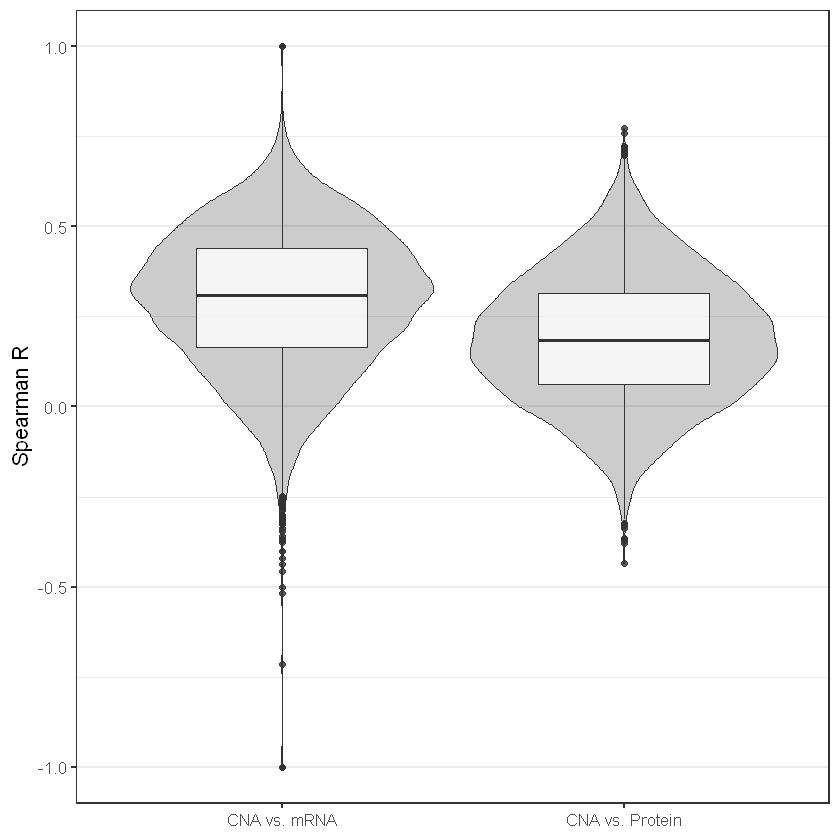

In [8]:
# Read the CNA table and use the clean_names function from the janitor package to standardize the names of the columns

cnaDF <- read.table(
    file = "resources/krug_et_al_2020/SCNA.gz",
    header = T,
    sep = "\t",
    comment.char = "",
    quote = "",
    stringsAsFactors = F
) %>%
    clean_names()


# Pivot to long format

cnaLongDF <- cnaDF  %>% 
    select(
        gene_id = id,
        starts_with("cpt"),
        starts_with("x")
    ) %>% 
    pivot_longer(
        cols = starts_with(c("x", "cpt")),
        names_to = "tumor",
        values_to = "cna_abundance"
    )


# Merge

cnaRnaProteinDF <- cnaLongDF %>% 
    full_join(
        rnaLongDF,
        by = c("gene_id", "tumor")
    ) %>% 
    full_join(
        proteinLongDF,
        by = c("gene_id", "tumor")
    )


# Compute the correlations CNA vs RNA and CNA vsprotein abundance estimates across tumors for every protein id

cnaRnaProteinCorrelationDF <- cnaRnaProteinDF  %>% 
    group_by(
        protein_id
    ) %>% 
    summarize(
        r_cna_rna = cor(
            x = cna_abundance, 
            y = mRNA_abundance, 
            use = "pairwise.complete.obs", 
            method = "spearman"
        ),
        r_cna_protein = cor(
            x = cna_abundance, 
            y = protein_abundance, 
            use = "pairwise.complete.obs", 
            method = "spearman"
        )
    )


# Build violin and box plot

plotDF <- cnaRnaProteinCorrelationDF  %>%
    pivot_longer(
        cols = c("r_cna_rna", "r_cna_protein"),
        names_to = "comparison",
        values_to = "r"
    )  %>% 
    mutate(
        comparison = factor(comparison, levels = c("r_cna_rna", "r_cna_protein"))
    ) %>% 
    filter(
        !is.na(r)
    )

levels(plotDF$comparison) <- c("CNA vs. mRNA", "CNA vs. Protein")

ggplot(
    data = plotDF
) +
    geom_violin(
        mapping = aes(
            x = comparison,
            y = r
        ),
        fill = "black",
        alpha = 0.2
    ) +
    geom_boxplot(
        mapping = aes(
            x = comparison,
            y = r
        ),
        fill = "white",
        alpha = 0.8,
        width = 0.5
    ) +
    scale_y_continuous(
        name = "Spearman R"
    ) +
    theme(
        axis.title.x = element_blank(),
        panel.grid.major.x = element_blank(),
        panel.grid.minor.x = element_blank()
    )

##### ❔ How do these correlation levels compare to the RNA vs. protein correlation? How do you interpret the fact that the correlation is in average lower for _CNA vs. Protein_ than _CNA vs. RNA_? 

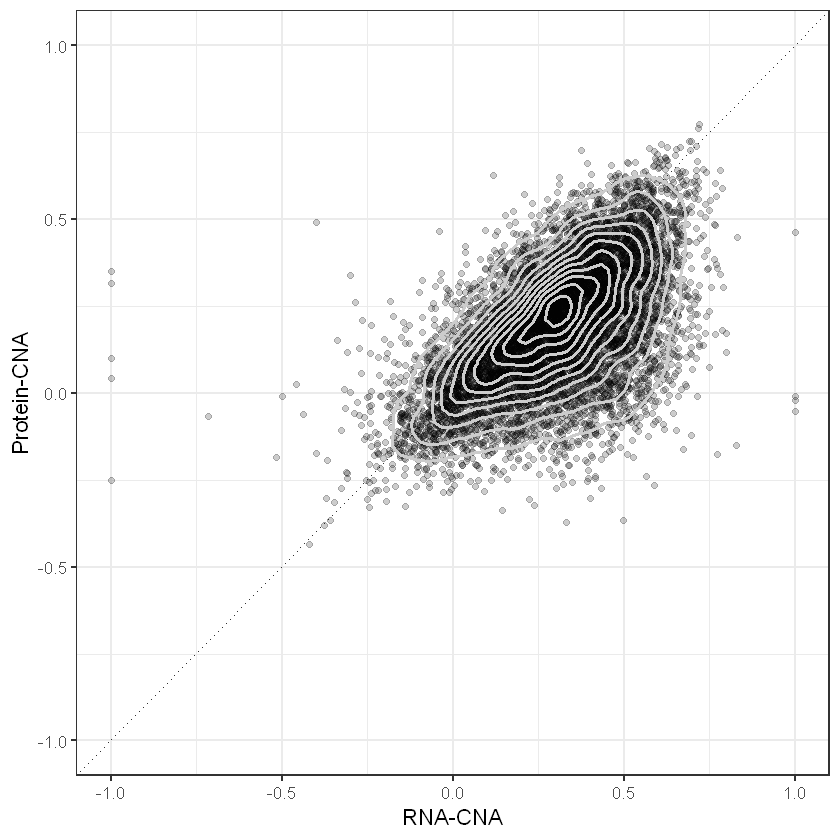

In [9]:
# In the following, we focus on proteins where we have correlation values with both RNA and protein

cnaRnaProteinCorrelationDF <- cnaRnaProteinCorrelationDF %>% 
    filter(
        !is.na(r_cna_rna) & !is.na(r_cna_protein)
    )


# Make a scatter plot

axisMin <- min(c(cnaRnaProteinCorrelationDF$r_cna_rna, cnaRnaProteinCorrelationDF$r_cna_protein))
axisMax <- max(c(cnaRnaProteinCorrelationDF$r_cna_rna, cnaRnaProteinCorrelationDF$r_cna_protein))

scatterPlot <- ggplot(
    data = cnaRnaProteinCorrelationDF
) +
    geom_abline(
        slope = 1,
        intercept = 0,
        linetype = "dotted",
        col = "black",
        alpha = 0.8
    ) +
    geom_point(
        mapping = aes(
            x = r_cna_rna,
            y = r_cna_protein
        ),
        col = "black",
        alpha = 0.2
    ) +
    geom_density_2d(
        mapping = aes(
            x = r_cna_rna,
            y = r_cna_protein
        ),
        col = "grey80",
        size = 0.9
    ) +
    scale_x_continuous(
        name = "RNA-CNA",
        limits = c(axisMin, axisMax)
    ) +
    scale_y_continuous(
        name = "Protein-CNA",
        limits = c(axisMin, axisMax)
    ) +
    theme(
        legend.position = "none"
    )

grid.draw(scatterPlot)

##### ❔ As you can see, points form a kind of triangle, how do you interpret this?

Copy number variation is associated with increased or decreased gene expression, but the association with protein abundances is less pronounced: the effect of CNAs is post-translationally attenuated. This was first discovered by [Gonçalves _et al._](https://pubmed.ncbi.nlm.nih.gov/29032074), confirmed by [Johansson _et al._](https://www.nature.com/articles/s41467-019-09018-y), and the results are strickingly consistent with this dataset.

##### 💬 In you opinion, what mechanisms can affect the association between CNA, gene expression, and protein abundances? 

When observing such patterns, it is useful to combing scatter and density plots. We are now going to plot the density of points on these directions and add them to the plot using the `grid` package.


##### 👨‍💻 Add densities on the x and y directions.

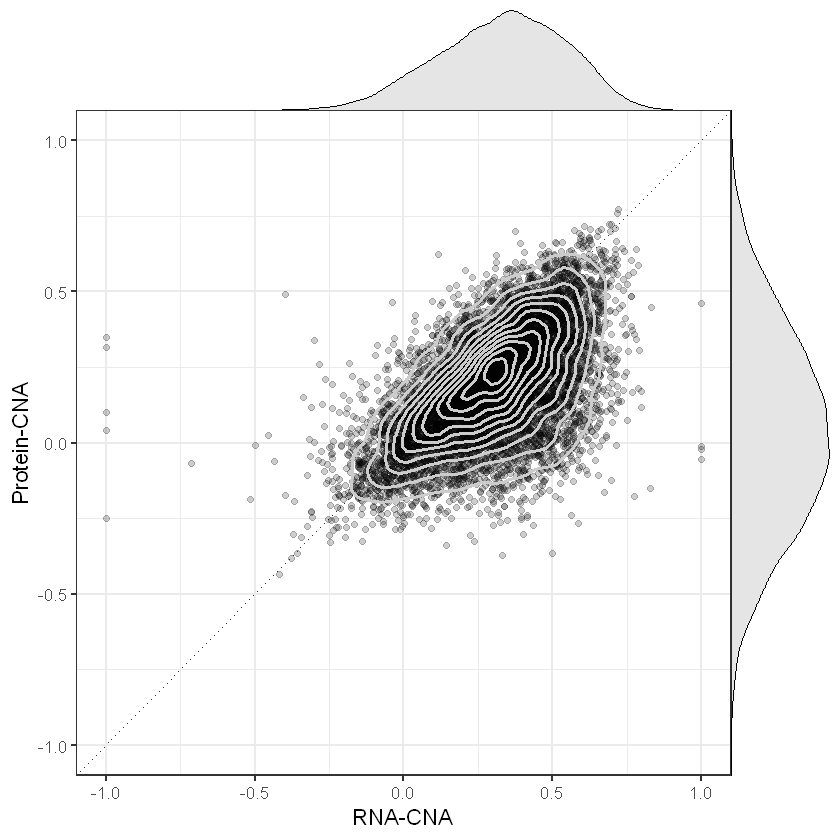

In [10]:
# Build the density plots

rnaDensityPlot <- ggplot(
    data = cnaRnaProteinCorrelationDF
) + theme_minimal() + 
    geom_density(
        mapping = aes(
            x = r_cna_rna
        ),
        fill = "black",
        alpha = 0.1
    ) +
    scale_x_continuous(
        expand = c(0, 0)
    ) +
    scale_y_continuous(
        expand = c(0, 0)
    ) +
    theme(
        axis.title = element_blank(),
        axis.text = element_blank(),
        panel.grid = element_blank()
    )

proteinDensityPlot <- ggplot(
    data = cnaRnaProteinCorrelationDF
) + theme_minimal() + 
    geom_density(
        mapping = aes(
            x = r_cna_protein
        ),
        fill = "black",
        alpha = 0.1
    ) +
    scale_x_continuous(
        expand = c(0, 0)
    ) +
    scale_y_continuous(
        expand = c(0, 0)
    ) +
    theme(
        axis.title = element_blank(),
        axis.text = element_blank(),
        panel.grid = element_blank()
    ) + 
    coord_flip()


# Make grobs from plots

scatterGrob <- ggplotGrob(scatterPlot)
rnaDensityGrob <- ggplotGrob(rnaDensityPlot)
proteinDensityGrob <- ggplotGrob(proteinDensityPlot)


# Insert the densities as new row and column in the scatter grob

mergedGrob <- rbind(scatterGrob[1:6, ], rnaDensityGrob[7, ], scatterGrob[7:nrow(scatterGrob), ], size = "last")
mergedGrob$heights[7] <- unit(0.15, "null")

proteinDensityGrob <- gtable_add_rows(
    x = proteinDensityGrob, 
    heights = unit(rep(0, nrow(mergedGrob) - nrow(proteinDensityGrob)), "null"), 
    pos = 0
)

mergedGrob <- cbind(mergedGrob[, 1:5], proteinDensityGrob[, 5], mergedGrob[, 6:ncol(mergedGrob)], size = "first")
mergedGrob$widths[6] <- unit(0.15, "null")


# Plot

grid.draw(mergedGrob)

Gonçalves _et al._ define the attenuation coefficient as the difference between the correlation of the transcript and protein levels with the CNA, where a positive and negative coefficient indicate a lower and higher correlation at the protein level, respectively.

##### 👨‍💻 Estimate the attenuation coefficient and plot its density.

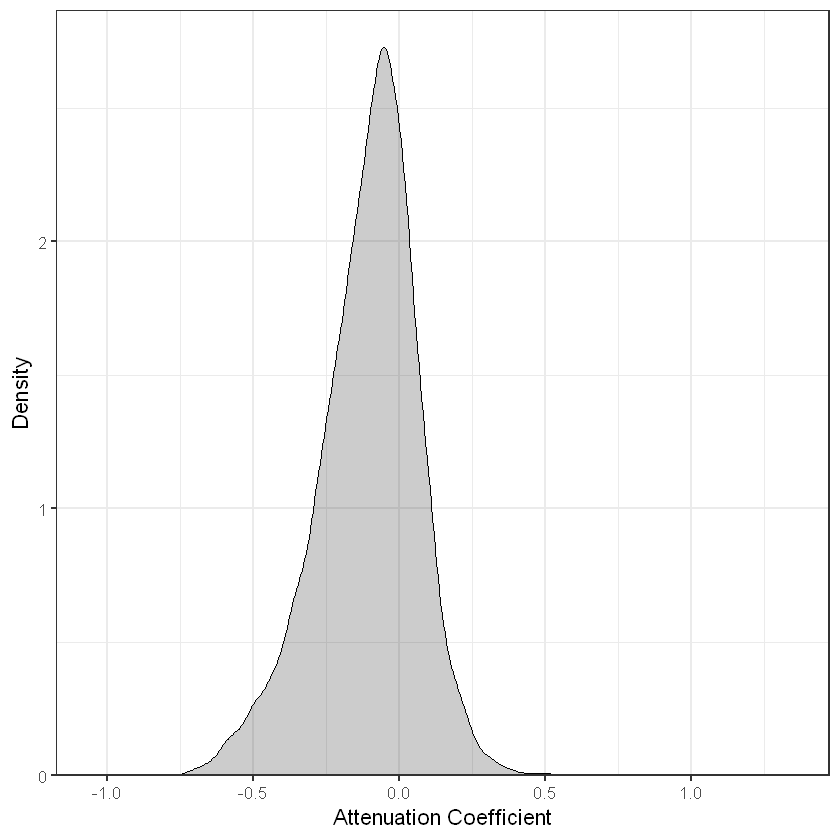

In [11]:
# Attenuation coefficient

cnaRnaProteinCorrelationDF <- cnaRnaProteinCorrelationDF %>%
    mutate(
        attenuation_coefficient = r_cna_protein - r_cna_rna
    )


# Build density plot

ggplot(
    data = cnaRnaProteinCorrelationDF
) +
    geom_density(
        mapping = aes(
            x = attenuation_coefficient
        ),
        fill = "black",
        alpha = 0.2
    ) +
    scale_x_continuous(
        name = "Attenuation Coefficient"
    ) +
    scale_y_continuous(
        name = "Density",
        expand =  expansion(
            mult = c(0, 0.05)
        )
    )

The authors suggest that this distribution is the combination of two populations of CNAs: post-translationally attenuated and not. They model the distributions of the two populations using Gaussian mixture modelling, where the overall density is decomposed into the sum of densities from Gaussian distributions. 

##### 👨‍💻 Run Gaussian mixture modelling on the attenuation coefficient.

In [12]:
gmm <- densityMclust(cnaRnaProteinCorrelationDF$attenuation_coefficient)

summary(gmm, parameters = TRUE)

------------------------------------------------------- 
Density estimation via Gaussian finite mixture modeling 
------------------------------------------------------- 

Mclust V (univariate, unequal variance) model with 3 components: 

 log-likelihood    n df      BIC       ICL
       3443.296 9447  8 6813.364 -369.2978

Mixing probabilities:
          1           2           3 
0.006719963 0.512189606 0.481090431 

Means:
          1           2           3 
-0.02606765 -0.16852216 -0.04489659 

Variances:
         1          2          3 
0.31208389 0.03784526 0.01100740 

##### ❔ How many gaussian distributions were suggested by the model? What do the _Mixing probabilities_, _Means_, and _Variances_ represent?

##### ❔ Based on tis, would you be able to estimate the share of CNAs that we can consider attenuated?

##### 👨‍💻 Overlay the density and the model.

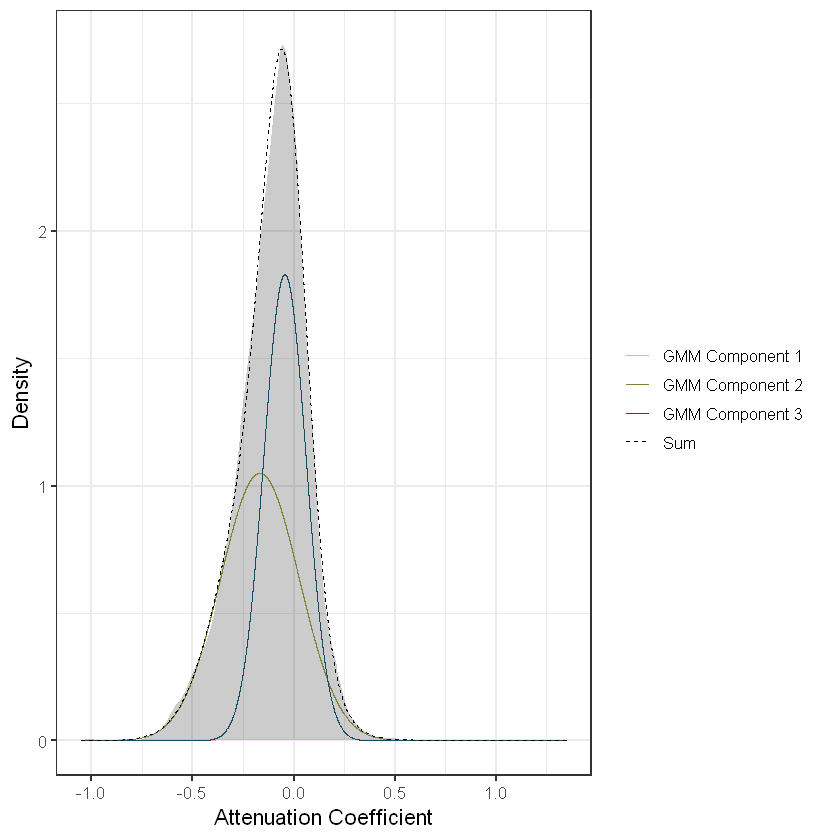

In [13]:
# Density from first component

gmm_density_1 <- gmm$parameters$pro[1] * dnorm(
    x = cnaRnaProteinCorrelationDF$attenuation_coefficient, 
    mean = gmm$parameters$mean[1], 
    sd = sqrt(gmm$parameters$variance$sigmasq[1])
)

# Density from second component

gmm_density_2 <- gmm$parameters$pro[2] * dnorm(
    x = cnaRnaProteinCorrelationDF$attenuation_coefficient, 
    mean = gmm$parameters$mean[2], 
    sd = sqrt(gmm$parameters$variance$sigmasq[2])
)

# Density from third component

gmm_density_3 <- gmm$parameters$pro[3] * dnorm(
    x = cnaRnaProteinCorrelationDF$attenuation_coefficient, 
    mean = gmm$parameters$mean[3], 
    sd = sqrt(gmm$parameters$variance$sigmasq[3])
)

# Sum

gmm_density_sum <- gmm_density_1 + gmm_density_2 + gmm_density_3


# Gather densities in a data frame

plotDF <- data.frame(
    x = c(
        rep(
            x = cnaRnaProteinCorrelationDF$attenuation_coefficient,
            4
        )
    ),
    y = c(
        gmm_density_1,
        gmm_density_2,
        gmm_density_3,
        gmm_density_sum
    ),
    category = factor(
        x = c(rep("GMM Component 1", nrow(cnaRnaProteinCorrelationDF)), rep("GMM Component 2", nrow(cnaRnaProteinCorrelationDF)), rep("GMM Component 3", nrow(cnaRnaProteinCorrelationDF)), rep("Sum", nrow(cnaRnaProteinCorrelationDF))),
        levels = c("GMM Component 1", "GMM Component 2", "GMM Component 3", "Sum")
    )
)

# Build overlayed density plot

ggplot() +
    geom_density(
        data = cnaRnaProteinCorrelationDF,
        mapping = aes(
            x = attenuation_coefficient
        ),
        fill = "black",
        col = NA,
        alpha = 0.2
    ) +
    geom_line(
        data = plotDF,
        mapping = aes(
            x = x,
            y = y,
            col = category,
            linetype = category
        )
    ) +
    scale_x_continuous(
        name = "Attenuation Coefficient"
    ) +
    scale_y_continuous(
        name = "Density"
    ) +
    scale_color_manual(
        values = c(
            scico(
                n = 3,
                palette = "batlow",
                begin = 0.2,
                end = 0.8,
                direction = -1
            ),
            "black"
        )
    ) +
    scale_linetype_manual(
        values = c(
            "solid",
            "solid",
            "solid",
            "dashed"
        )
    ) +
    theme(
        legend.title = element_blank()
    )

##### ❔ Which component represents the attenuated distribution? How can we classify CNAs based on these distributions?

##### 💬 What do you think of the quality of the modelling?

In the following, we will ignore the first component, and use the cumulative distribution function of the third component to scale the attenuation coefficient, and use the biologists' favorite threshold of 0.05 to highlight the confidently attenuated CNAs.

##### 👨‍💻 Scale the attenuation coefficient, threshold at 0.05, and plot on top of the distributions.

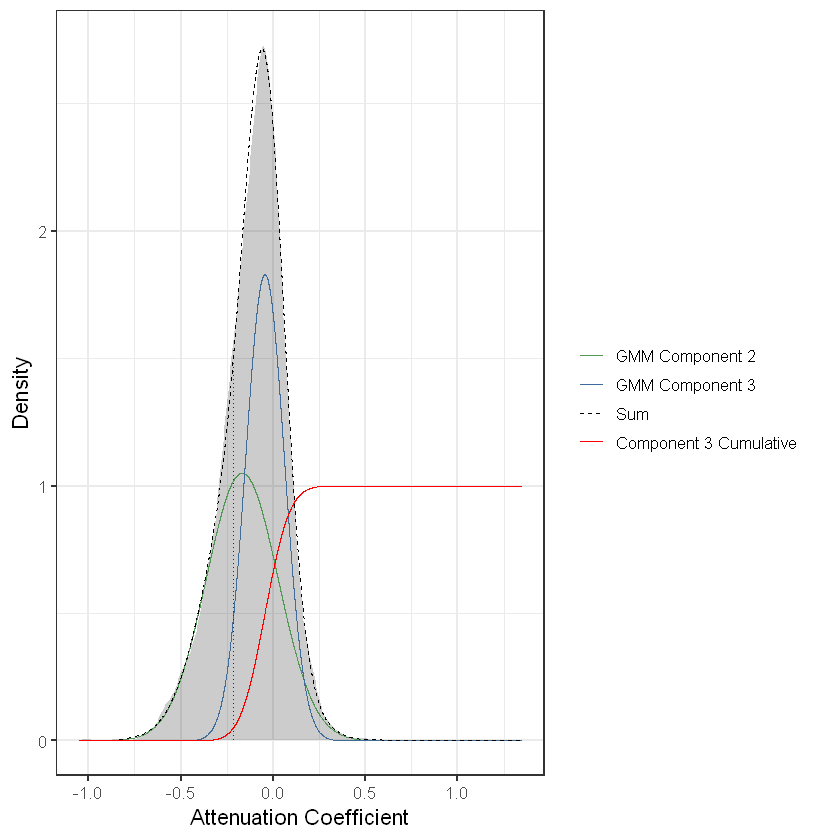

In [14]:
# Scale the attenuation coefficient

cnaRnaProteinCorrelationDF$attenuation_p <- pnorm(
    q = cnaRnaProteinCorrelationDF$attenuation_coefficient,
    mean = gmm$parameters$mean[3],
    sd = sqrt(gmm$parameters$variance$sigmasq[3])
)


# Threshold at 0.05

cnaRnaProteinCorrelationDF$attenuation_category <- factor(
    x = ifelse(cnaRnaProteinCorrelationDF$attenuation_p <= 0.05, "Attenuated", "Background"),
    levels = c("Attenuated", "Background")
)


# Gather densities in a data frame

plotDF <- data.frame(
    x = c(
        rep(
            x = cnaRnaProteinCorrelationDF$attenuation_coefficient,
            4
        )
    ),
    y = c(
        gmm_density_2,
        gmm_density_3,
        gmm_density_sum,
        cnaRnaProteinCorrelationDF$attenuation_p
    ),
    category = factor(
        x = c(rep("GMM Component 2", nrow(cnaRnaProteinCorrelationDF)), rep("GMM Component 3", nrow(cnaRnaProteinCorrelationDF)), rep("Sum", nrow(cnaRnaProteinCorrelationDF)), rep("Component 3 Cumulative", nrow(cnaRnaProteinCorrelationDF))),
        levels = c("GMM Component 2", "GMM Component 3", "Sum", "Component 3 Cumulative")
    )
)

# Build overlayed density plot

xThreshold <- qnorm(
    p = 0.05,
    mean = gmm$parameters$mean[3],
    sd = sqrt(gmm$parameters$variance$sigmasq[3])
)
yThreshold <- gmm$parameters$pro[2] * dnorm(
    x = xThreshold, 
    mean = gmm$parameters$mean[2], 
    sd = sqrt(gmm$parameters$variance$sigmasq[2])
) + 
gmm$parameters$pro[3] * dnorm(
    x = xThreshold, 
    mean = gmm$parameters$mean[3], 
    sd = sqrt(gmm$parameters$variance$sigmasq[3])
)

ggplot() +
    geom_density(
        data = cnaRnaProteinCorrelationDF,
        mapping = aes(
            x = attenuation_coefficient
        ),
        fill = "black",
        col = NA,
        alpha = 0.2
    ) +
    geom_line(
        data = plotDF,
        mapping = aes(
            x = x,
            y = y,
            col = category,
            linetype = category
        )
    ) +
    geom_segment(
        mapping = aes(
            x = xThreshold,
            xend = xThreshold,
            y = 0,
            yend = yThreshold
        ),
        linetype = "dotted",
        col = "darkred"
    ) +
    scale_x_continuous(
        name = "Attenuation Coefficient"
    ) +
    scale_y_continuous(
        name = "Density"
    ) +
    scale_color_manual(
        values = c(
            scico(
                n = 2,
                palette = "cork",
                begin = 0.2,
                end = 0.8,
                direction = -1
            ),
            "black",
            "red"
        )
    ) +
    scale_linetype_manual(
        values = c(
            "solid",
            "solid",
            "dashed",
            "solid"
        )
    ) +
    theme(
        legend.title = element_blank()
    )

##### ❔ Using this threshold: What is the share of CNAs considered attenuated that would come from the component 2 distribution? What is the share of CNAs considered not attenuated that would come from the component 1? How will this influence the analyses?

##### 👨‍💻 Highlight the attenuated CNAs in the scatter plot.

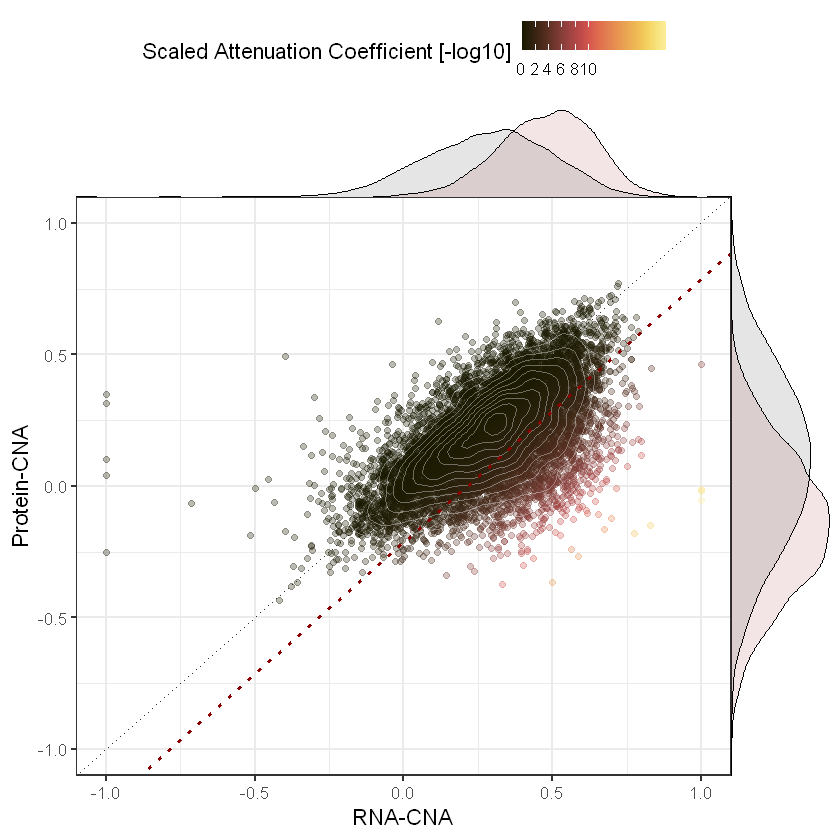

In [15]:
# Build the scatter plot with points colored by (logged) attenuation coefficient

axisMin <- min(c(cnaRnaProteinCorrelationDF$r_cna_rna, cnaRnaProteinCorrelationDF$r_cna_protein))
axisMax <- max(c(cnaRnaProteinCorrelationDF$r_cna_rna, cnaRnaProteinCorrelationDF$r_cna_protein))

cnaRnaProteinCorrelationDF <- cnaRnaProteinCorrelationDF %>%
    arrange(
        desc(attenuation_p)
    )

scatterPlot <- ggplot(
    data = cnaRnaProteinCorrelationDF
) +
    geom_abline(
        slope = 1,
        intercept = 0,
        linetype = "dotted",
        col = "black",
        alpha = 0.8
    ) +
    geom_point(
        mapping = aes(
            x = r_cna_rna,
            y = r_cna_protein,
            col = -log10(attenuation_p)
        ),
        alpha = 0.3
    ) +
    geom_density_2d(
        mapping = aes(
            x = r_cna_rna,
            y = r_cna_protein
        ),
        col = "grey90",
        alpha = 0.4
    ) +
    geom_abline(
        slope = 1,
        intercept = xThreshold,
        color = "darkred",
        linetype = "dotted",
        size = 0.9
    ) +
    scale_color_scico(
        name = "Scaled Attenuation Coefficient [-log10]",
        palette = "lajolla",
        direction = -1,
        begin = 0.1,
        breaks = seq(0, 10, 2)
    ) +
    scale_x_continuous(
        name = "RNA-CNA",
        limits = c(axisMin, axisMax)
    ) +
    scale_y_continuous(
        name = "Protein-CNA",
        limits = c(axisMin, axisMax)
    ) +
    theme(
        legend.position = "top"
    )


# Build the density plots separating the points passing the attenuation threshold

rnaDensityPlot <- ggplot(
    data = cnaRnaProteinCorrelationDF
) + theme_minimal() + 
    geom_density(
        mapping = aes(
            x = r_cna_rna,
            fill = attenuation_category
        ),
        alpha = 0.1
    ) +
    scale_fill_manual(
        values = c("darkred", "black")
    ) +
    scale_x_continuous(
        expand = c(0, 0)
    ) +
    scale_y_continuous(
        expand = c(0, 0)
    ) +
    theme(
        legend.position = "none",
        axis.title = element_blank(),
        axis.text = element_blank(),
        panel.grid = element_blank()
    )

proteinDensityPlot <- ggplot(
    data = cnaRnaProteinCorrelationDF
) + theme_minimal() + 
    geom_density(
        mapping = aes(
            x = r_cna_protein,
            fill = attenuation_category
        ),
        alpha = 0.1
    ) +
    scale_fill_manual(
        values = c("darkred", "black")
    ) +
    scale_x_continuous(
        expand = c(0, 0)
    ) +
    scale_y_continuous(
        expand = c(0, 0)
    ) +
    theme(
        legend.position = "none",
        axis.title = element_blank(),
        axis.text = element_blank(),
        panel.grid = element_blank()
    ) + 
    coord_flip()


# Make grobs from plots

scatterGrob <- ggplotGrob(scatterPlot)
rnaDensityGrob <- ggplotGrob(rnaDensityPlot)
proteinDensityGrob <- ggplotGrob(proteinDensityPlot)


# Insert the densities as new row and column in the scatter grob

mergedGrob <- rbind(scatterGrob[1:8, ], rnaDensityGrob[7, ], scatterGrob[9:nrow(scatterGrob), ], size = "last")
mergedGrob$heights[9] <- unit(0.15, "null")

proteinDensityGrob <- gtable_add_rows(
    x = proteinDensityGrob, 
    heights = unit(rep(0, nrow(mergedGrob) - nrow(proteinDensityGrob)), "null"), 
    pos = 0
)

mergedGrob <- cbind(mergedGrob[, 1:5], proteinDensityGrob[, 5], mergedGrob[, 6:ncol(mergedGrob)], size = "first")
mergedGrob$widths[6] <- unit(0.15, "null")


# Plot

grid.draw(mergedGrob)

##### 💬 Can you speculate on the mechanism underlying CNA attenuation? How would you use this in the context of cancer research?